Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Evaluation Metrics:
Accuracy: 0.8692537313432835
Precision: 0.8781702898550725
Recall: 0.9198292220113852
F1-Score: 0.8985171455050974
ROC-AUC Score: 0.8516215353213126


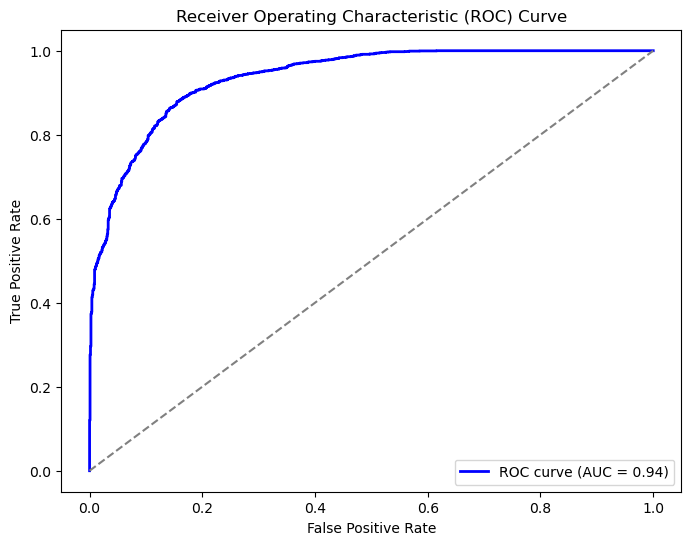

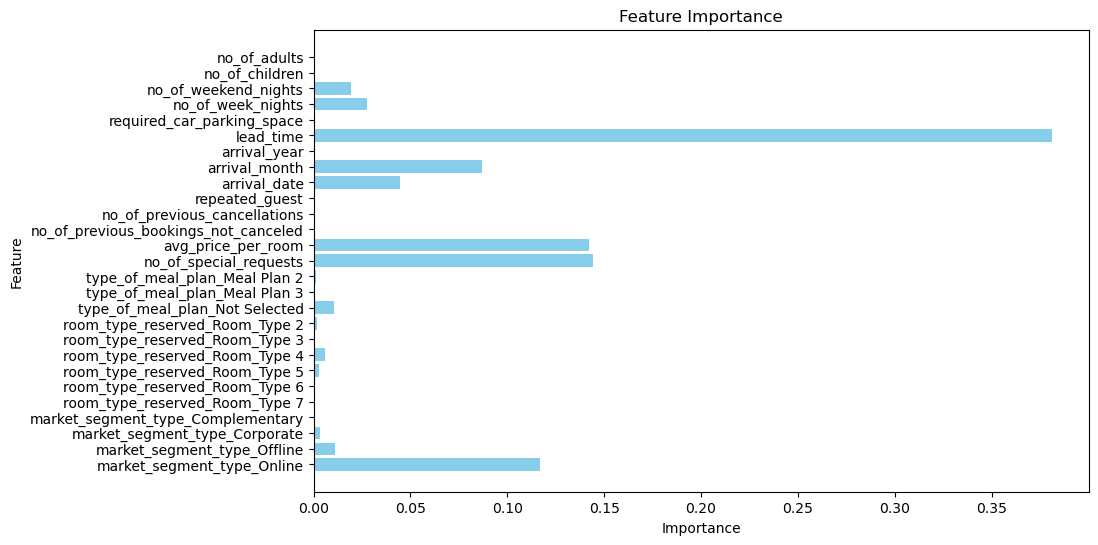

In [1]:
import warnings
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Filter out any warnings
warnings.filterwarnings("ignore")

# Step 1: Read the cleaned dataset
df_cleaned = pd.read_csv('cleaned_dataset1.csv')

# Step 1.1: Drop non-numeric columns if needed
df_cleaned.drop(columns=['Booking_ID'], inplace=True)

# Step 2: Split the dataset into features (X) and target variable (y)
X = df_cleaned.drop(columns=['booking_status_Not_Canceled'])
y = df_cleaned['booking_status_Not_Canceled']

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define preprocessing steps
numeric_features = X.columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = numeric_transformer

# Step 5: Define the model
gbm_classifier = GradientBoostingClassifier()

# Step 6: Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', gbm_classifier)])

# Step 7: Define the hyperparameters grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

# Step 8: Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')

# Step 9: Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

# Step 10: Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Step 11: Make predictions on the testing data using the best model
y_pred = best_model.predict(X_test)

# Step 12: Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("\nEvaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC-AUC Score:", roc_auc)

# Step 13: Pickle the Gradient Boosting model for deployment
with open('gbm_best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Step 14: Plot ROC-AUC curve
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Step 15: Plot feature importance
feature_importance = best_model.named_steps['classifier'].feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()